In [312]:
# Import av dependencies
%matplotlib inline

# Python imports
import math, time, random, datetime
import category_encoders as ce

# Data manipulation
import numpy as np
import pandas as pd

# Visualisering
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, MinMaxScaler

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report as classifier

# Ignorera varningar (för nu)
import warnings
warnings.filterwarnings('ignore')

# Import av träningsdata
train = pd.read_csv('data/weatherAUS.csv')

# Överblick av träningsdatan
train.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


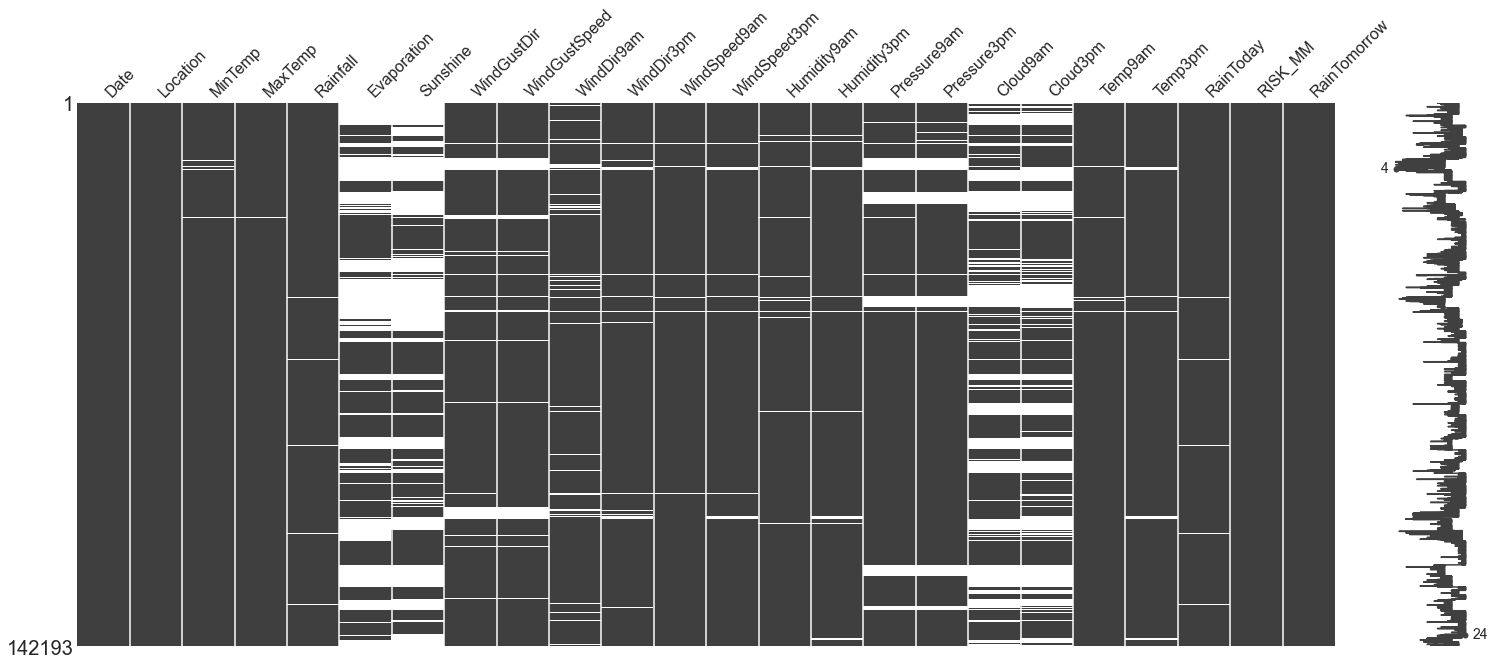

In [313]:
# Ta fram saknade värden i datan
missingno.matrix(train)

In [314]:
# Ta fram saknade värden i datan, alt 2
train.isnull().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

In [315]:
# Metadata över NUMERISK data weatherAUS.csv
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [316]:
# Metadata över KATEGORISK data weatherAUS.csv
train.describe(include=['object'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,142193,142193,132863,132180,138415,140787,142193
unique,3436,49,16,16,16,2,2
top,2013-07-01,Canberra,W,N,SE,No,No
freq,49,3418,9780,11393,10663,109332,110316


In [317]:
# Droppar riskvariablen enligt instruktion
train.drop(['RISK_MM'], axis=1, inplace=True)

In [318]:
# Ta fram de olika datatyperna
train.dtypes

Date              object
Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

There are 0 null values


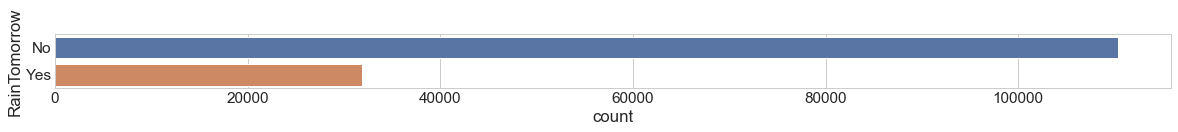

In [319]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y='RainTomorrow', data=train);
print(train.RainTomorrow.value_counts())
print('\nThere are {} null values'.format(train.RainTomorrow.isnull().sum()))

In [321]:
# Parse date från string -> datetime samt tar bort date från train
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train['Date'].dt.year
train['Month'] = train['Date'].dt.month
train['Day'] = train['Date'].dt.day
train.drop('Date', axis=1, inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

In [322]:
# Går igenom kolumnerna och tar fram alla kategoriska variabler och lägger i en list
cat = [var for var in train.columns if train[var].dtype=='O']
print('There are {} categorical variables\n'.format(len(cat)))
print('The numerical variables are :', cat)

There are 6 categorical variables

The numerical variables are : ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [323]:
train[cat].isnull().sum()

Location            0
WindGustDir      9330
WindDir9am      10013
WindDir3pm       3778
RainToday        1406
RainTomorrow        0
dtype: int64

In [324]:
# One Hot Enconding på Location för att göra datasetet numeriskt för modelering
pd.get_dummies(train.Location, drop_first=True).head()

,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,...,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [325]:
# Kollar efter unika datapunkter
train.WindGustDir.unique()

array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
       'S', 'NW', 'SE', 'ESE', nan, 'E', 'SSW'], dtype=object)

In [326]:
# One Hot Encoding på WindGustDir precis som med Location, men lägger till dummy_na som kolumn (NaN)
# då dessa behöver feature enginering längre fram
pd.get_dummies(train.WindGustDir, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [327]:
# Kollar efter unika datapunkter
train.WindDir9am.unique()

array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', nan, 'SSW', 'N',
       'WSW', 'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object)

In [328]:
# Samma som med WindGustDir ^
pd.get_dummies(train.WindDir9am, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [329]:
# Kollar efter unika datapunkter
train.WindDir3pm.unique()

array(['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
       'SW', 'SE', 'N', 'S', 'NNE', nan, 'NE'], dtype=object)

In [330]:
# Samma som med WindGustDir ^
pd.get_dummies(train.WindDir3pm, drop_first=True, dummy_na=True).head()

,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,NaN
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [331]:
train.RainToday.unique()

array(['No', 'Yes', nan], dtype=object)

In [332]:
print(train.RainToday.value_counts())
print('\nThere are {} null values'.format(train.RainToday.isnull().sum()))

No     109332
Yes     31455
Name: RainToday, dtype: int64

There are 1406 null values


In [333]:
# One Hot Encoding... "No"-label försvinner då 0(noll) på yes betyder "No"
pd.get_dummies(train.RainToday, drop_first=True, dummy_na=True).head()

,Yes,NaN
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [334]:
# Går igenom kolumnerna och tar fram alla numeriska variabler och lägger i en list
num = [var for var in train.columns if train[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(num)))
print('The numerical variables are :', num)

There are 19 numerical variables

The numerical variables are : ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']


In [335]:
train[num].head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,2008,12,1
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,2008,12,2
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,2008,12,3
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,2008,12,4
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008,12,5


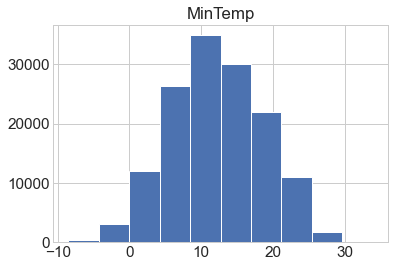

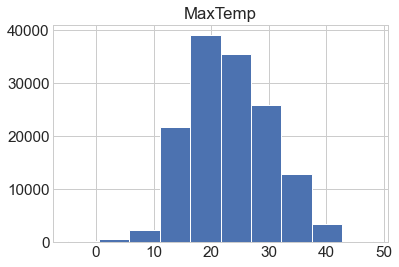

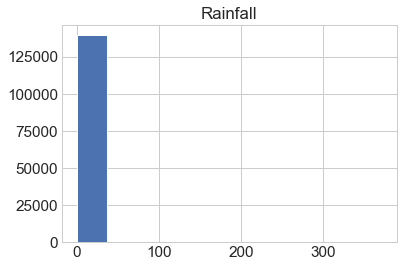

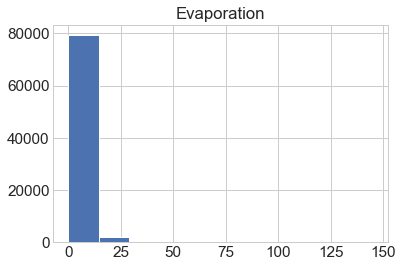

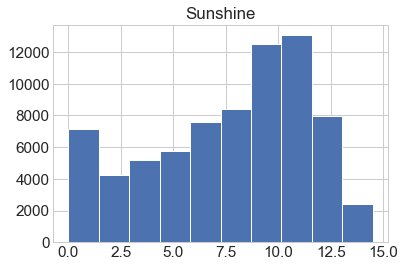

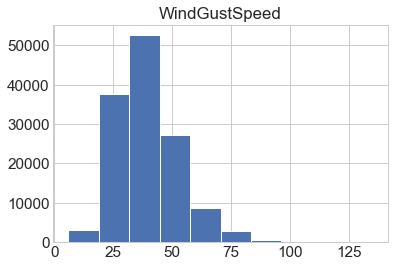

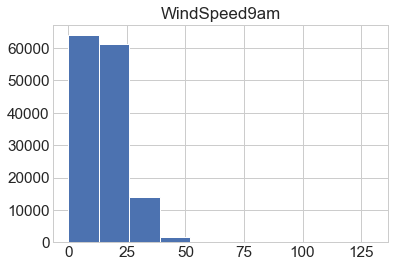

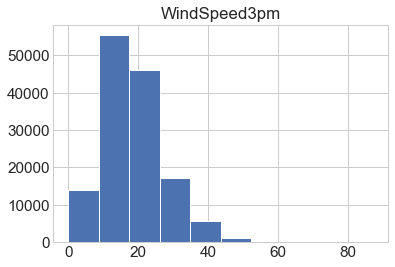

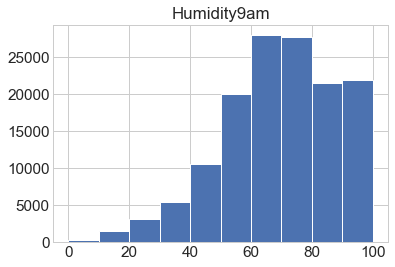

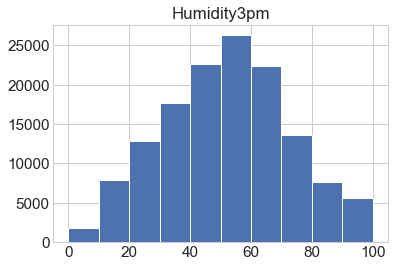

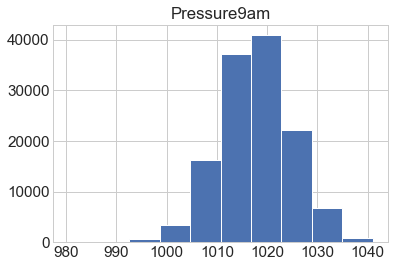

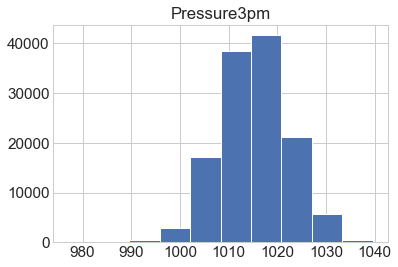

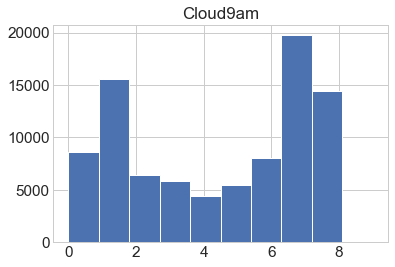

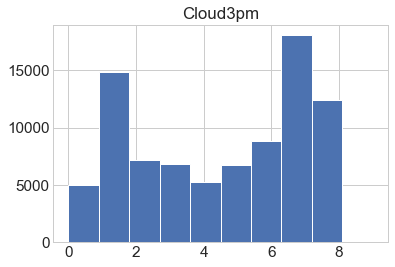

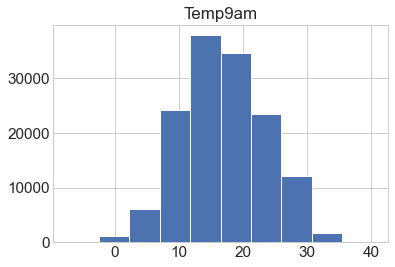

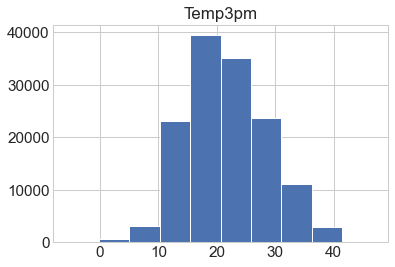

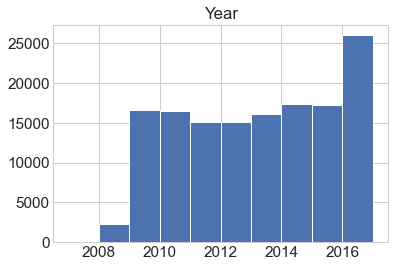

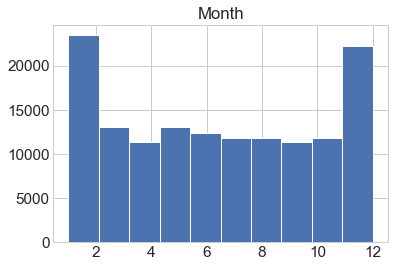

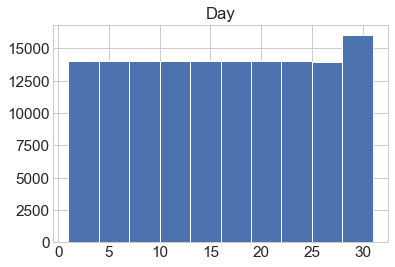

<Figure size 432x288 with 0 Axes>

In [336]:
for i in train[num].columns:
    plt.hist(train[num][i])
    plt.title(i)
    plt.show()  
plt.tight_layout()

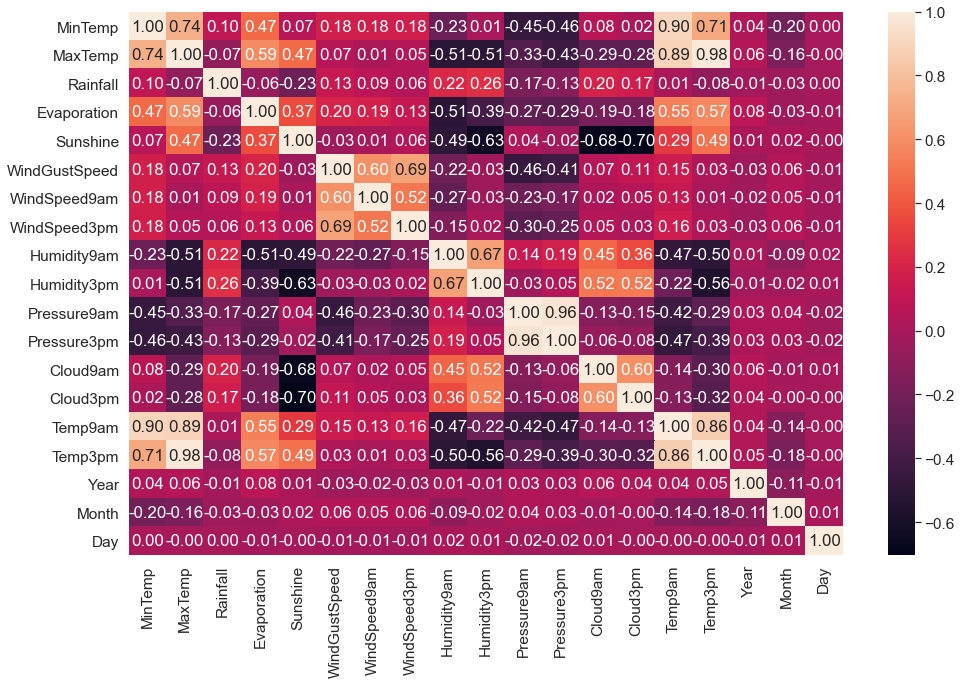

In [337]:
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.4)
sns.heatmap(train.corr(), annot=True, fmt='.2f')

In [338]:
# Kollar efter antal null per kolumn
train[num].isnull().sum()

MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustSpeed     9270
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
Year                 0
Month                0
Day                  0
dtype: int64

In [339]:
print(train[num].describe())

             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000      31.000000       7.0000

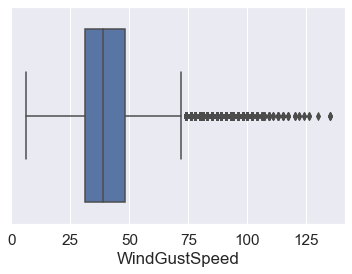

In [340]:
# Rainfall, Evaporation, WindSpeed9am&3pm har tydliga outliers. Hur är det med WindGustspeed?
sns.boxplot(x=train.WindGustSpeed)

In [341]:
def FindOutliers(x):
    IQR = x.quantile(0.75) - x.quantile(0.25)
    Lower = x.quantile(0.25) - (IQR * 3)
    Upper = x.quantile(0.75) + (IQR * 3)
    print('{y}: Lower outlier {loweroutlier} and Upper outlier {upperoutlier}'.format(y=x.name, loweroutlier=Lower, upperoutlier=Upper))

FindOutliers(train.Rainfall)
FindOutliers(train.Evaporation)
FindOutliers(train.WindSpeed9am)
FindOutliers(train.WindSpeed3pm)
FindOutliers(train.WindGustSpeed)

Rainfall: Lower outlier -2.4000000000000004 and Upper outlier 3.2
Evaporation: Lower outlier -11.800000000000002 and Upper outlier 21.800000000000004
WindSpeed9am: Lower outlier -29.0 and Upper outlier 55.0
WindSpeed3pm: Lower outlier -20.0 and Upper outlier 57.0
WindGustSpeed: Lower outlier -20.0 and Upper outlier 99.0


In [342]:
# Deklarerar target-variabel (y)
X = train.drop(['RainTomorrow'], axis=1)
y = train['RainTomorrow']

In [343]:
# Splittar upp tränings- och testdata. random_state=0 för konsekventare resultat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Shape
X_train.shape, X_test.shape

((113754, 24), (28439, 24))

In [344]:
X_train.dtypes

Location          object
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday         object
Year               int64
Month              int64
Day                int64
dtype: object

In [345]:
# Delar upp datan i kategorisk och numerisk, börjar med kategorisk
cat = [col for col in X_train.columns if X_train[col].dtypes=='O']

cat

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [346]:
# Delar upp i numerisk
num = [col for col in X_train.columns if X_train[col].dtypes!='O']

print('Numericals:\n\n',num) 
print('\nThere are {} unique numerical values'.format(len(num)))
print('\nMissing values:')
X_train[num].isnull().sum()

Numericals:

 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'Year', 'Month', 'Day']

There are 19 unique numerical values

Missing values:


MinTemp            495
MaxTemp            264
Rainfall          1139
Evaporation      48718
Sunshine         54314
WindGustSpeed     7367
WindSpeed9am      1086
WindSpeed3pm      2094
Humidity9am       1449
Humidity3pm       2890
Pressure9am      11212
Pressure3pm      11186
Cloud9am         43137
Cloud3pm         45768
Temp9am            740
Temp3pm           2171
Year                 0
Month                0
Day                  0
dtype: int64

In [347]:
# Saknad data i testsettet
X_test[num].isnull().sum()

MinTemp            142
MaxTemp             58
Rainfall           267
Evaporation      12125
Sunshine         13502
WindGustSpeed     1903
WindSpeed9am       262
WindSpeed3pm       536
Humidity9am        325
Humidity3pm        720
Pressure9am       2802
Pressure3pm       2795
Cloud9am         10520
Cloud3pm         11326
Temp9am            164
Temp3pm            555
Year                 0
Month                0
Day                  0
dtype: int64

In [348]:
for i in [X_train, X_test]:
    for col in num:
        col_median=X_train[col].median()
        i[col].fillna(col_median, inplace=True)
print('NA kolumner fyllda med medianvärdet i X_train\n')
print('Antal null-värden i X_train:\n', X_train[num].isnull().sum())

NA kolumner fyllda med medianvärdet i X_train

Antal null-värden i X_train:
 MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Year             0
Month            0
Day              0
dtype: int64


In [349]:
print('NA kolumner fyllda med medianvärdet i X_test\n')
print('Antal null-värden i X_test:\n', X_test[num].isnull().sum())

NA kolumner fyllda med medianvärdet i X_test

Antal null-värden i X_test:
 MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Year             0
Month            0
Day              0
dtype: int64


In [350]:
# NA värden saknade i kategoriska värden
X_train[cat].isnull().sum()

Location          0
WindGustDir    7407
WindDir9am     7978
WindDir3pm     3008
RainToday      1139
dtype: int64

In [351]:
# Tar fram endast kolumner med NA-värden, lägger i en ny lista samt printar ut dem. 
# Andra for-loopen tar bort alla NA-värden ur X_train & X_test
for j in cat:
    if X_train[j].isnull().mean()>0.:
        catNull = X_train[j].isnull().mean()
        print(j, catNull)
        for k in [X_train, X_test]:
            k[j].fillna(X_train[j].mode()[0], inplace=True)

WindGustDir 0.06511419378659213
WindDir9am 0.07013379749283542
WindDir3pm 0.026443026179299188
RainToday 0.01001283471350458


In [352]:
# Hur många null?
X_train[cat].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

In [353]:
# Hur många null?
X_test[cat].isnull().sum()

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

In [354]:
# Hur många null, alla kolumner
X_train.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

In [355]:
# Hur många null, alla kolumner
X_test.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

In [356]:
FindOutliers(train.Rainfall)
FindOutliers(train.Evaporation)
FindOutliers(train.WindSpeed9am)
FindOutliers(train.WindSpeed3pm)
FindOutliers(train.WindGustSpeed)

Rainfall: Lower outlier -2.4000000000000004 and Upper outlier 3.2
Evaporation: Lower outlier -11.800000000000002 and Upper outlier 21.800000000000004
WindSpeed9am: Lower outlier -29.0 and Upper outlier 55.0
WindSpeed3pm: Lower outlier -20.0 and Upper outlier 57.0
WindGustSpeed: Lower outlier -20.0 and Upper outlier 99.0


In [357]:
def max_value(t, var, top):
    return np.where(t[var]>top, top, t[var])

for t in [X_train, X_test]:
    t['Rainfall'] = max_value(t, 'Rainfall', 3.2)
    t['Evaporation'] = max_value(t, 'Evaporation', 21.8)
    t['WindSpeed9am'] = max_value(t, 'WindSpeed9am', 55)
    t['WindSpeed3pm'] = max_value(t, 'WindSpeed3pm', 57)
    t['WindGustSpeed'] = max_value(t, 'WindGustSpeed', 99)

In [358]:
X_train.Rainfall.max(), X_train.Evaporation.max(), X_train.WindSpeed9am.max(), X_train.WindSpeed3pm.max(), X_train.WindGustSpeed.max()

(3.2, 21.8, 55.0, 57.0, 99.0)

In [359]:
X_train['RainToday']
encoder = ce.BinaryEncoder(cols=['RainToday'])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_0,RainToday_1,Year,Month,Day
110803,Witchcliffe,13.9,22.6,0.2,4.8,8.5,S,41.0,SSE,S,...,1013.4,5.0,5.0,18.8,20.4,0,1,2014,4,25
87289,Cairns,22.4,29.4,2.0,6.0,6.3,ENE,33.0,SSE,SE,...,1013.1,7.0,5.0,26.4,27.5,1,0,2015,11,2
134949,AliceSprings,9.7,36.2,0.0,11.4,12.3,E,31.0,NE,N,...,1013.6,1.0,1.0,28.5,35.0,0,1,2014,10,19
85553,Cairns,20.5,30.1,0.0,8.8,11.1,ESE,37.0,SSE,E,...,1010.8,2.0,3.0,27.3,29.4,0,1,2010,10,30
16110,Newcastle,16.8,29.2,0.0,4.8,8.5,W,39.0,N,SE,...,1015.2,5.0,8.0,22.2,27.0,0,1,2012,11,8


In [360]:
X_train = pd.concat([X_train[num], X_train[['RainToday_0', 'RainToday_1']],
                    pd.get_dummies(X_train.Location),
                    pd.get_dummies(X_train.WindGustDir),
                    pd.get_dummies(X_train.WindDir9am),
                    pd.get_dummies(X_train.WindDir3pm)], axis=1)
X_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
110803,13.9,22.6,0.2,4.8,8.5,41.0,20.0,28.0,65.0,55.0,...,0,0,1,0,0,0,0,0,0,0
87289,22.4,29.4,2.0,6.0,6.3,33.0,7.0,19.0,71.0,59.0,...,0,0,0,1,0,0,0,0,0,0
134949,9.7,36.2,0.0,11.4,12.3,31.0,15.0,11.0,6.0,2.0,...,0,0,0,0,0,0,0,0,0,0
85553,20.5,30.1,0.0,8.8,11.1,37.0,22.0,19.0,59.0,53.0,...,0,0,0,0,0,0,0,0,0,0
16110,16.8,29.2,0.0,4.8,8.5,39.0,0.0,7.0,72.0,53.0,...,0,0,0,1,0,0,0,0,0,0


In [361]:
X_test = pd.concat([X_test[num], X_test[['RainToday_0', 'RainToday_1']],
                     pd.get_dummies(X_test.Location), 
                     pd.get_dummies(X_test.WindGustDir),
                     pd.get_dummies(X_test.WindDir9am),
                     pd.get_dummies(X_test.WindDir3pm)], axis=1)
X_test.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
86232,17.4,29.0,0.0,3.6,11.1,33.0,11.0,19.0,63.0,61.0,...,0,0,0,0,0,0,0,0,0,0
57576,6.8,14.4,0.8,0.8,8.5,46.0,17.0,22.0,80.0,55.0,...,0,0,1,0,0,0,0,0,0,0
124071,10.1,15.4,3.2,4.8,8.5,31.0,13.0,9.0,70.0,61.0,...,0,0,0,0,1,0,0,0,0,0
117955,14.4,33.4,0.0,8.0,11.6,41.0,9.0,17.0,40.0,23.0,...,0,0,0,0,0,0,1,0,0,0
133468,6.8,14.3,3.2,0.2,7.3,28.0,15.0,13.0,92.0,47.0,...,0,0,0,0,0,0,0,0,0,0


In [362]:
cols = X_train.columns

In [363]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [364]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [365]:
X_train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,...,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000,113754.000000
mean,0.484406,0.530004,0.210962,0.236312,0.554562,0.364257,0.254148,0.326575,0.688675,0.515095,...,0.054530,0.060288,0.067259,0.101605,0.064059,0.056402,0.064464,0.069334,0.060798,0.065483
std,0.151741,0.134105,0.369949,0.129528,0.190999,0.140598,0.160119,0.152384,0.189356,0.205307,...,0.227061,0.238021,0.250471,0.302130,0.244860,0.230698,0.245578,0.254022,0.238960,0.247378
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.375297,0.431002,0.000000,0.183486,0.565517,0.268817,0.127273,0.228070,0.570000,0.370000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.479810,0.517958,0.000000,0.220183,0.586207,0.354839,0.236364,0.333333,0.700000,0.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.593824,0.623819,0.187500,0.247706,0.600000,0.430108,0.345455,0.421053,0.830000,0.650000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [366]:
logreg = LogisticRegression(solver='liblinear', random_state=0)

logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [367]:
y_pred_test = logreg.predict(X_test)

y_pred_test

array(['No', 'No', 'No', ..., 'No', 'No', 'Yes'], dtype=object)

In [368]:
logreg.predict_proba(X_test)[:,0]

array([0.91387416, 0.83527165, 0.82103661, ..., 0.9768263 , 0.79869717,
       0.30804463])

In [369]:
logreg.predict_proba(X_test)[:,1]

array([0.08612584, 0.16472835, 0.17896339, ..., 0.0231737 , 0.20130283,
       0.69195537])

In [370]:
print('Model acc score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

Model acc score: 0.8505


In [371]:
y_pred_train = logreg.predict(X_train)

y_pred_train

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [372]:
print('Model acc score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))

Model acc score: 0.8476


In [376]:
#def modelFitting(model, training, testing, cross_validation):
ar = []
for h in X_train.columns:
    ar.append(h)
    print(ar)

[('MinTemp',)]
[('MinTemp',), ('MaxTemp',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',), ('WindSpeed9am',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',), ('WindSpeed9am',), ('WindSpeed3pm',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',), ('WindSpeed9am',), ('WindSpeed3pm',), ('Humidity9am',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',), ('WindSpeed9am',), ('WindSpeed3pm',), ('Humidity9am',), ('Humidity3pm',)]
[('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',), ('Sunshine',), ('WindGustSpeed',), ('Wi

In [422]:
# logreg = model
#importance = pd.DataFrame({'Importance': logreg.coef_, 'Column': X_train})
#importance = model.coef_[0]
#abc = logreg.coef_[0]
#abc[0][0]
#abc[0][1]
#imp = pd.DataFrame({'imp': abc, 'col': X_train.columns})
#imp = imp.sort_values(['imp', 'col'], ascending=[True, False])
#imp
#X_train.columns
#imp.sort_values(ascending[True, False])
#len(logreg.coef_[0])
#print(X_train.columns.values)
abc = np.array(X_train.columns)
abc

array([('MinTemp',), ('MaxTemp',), ('Rainfall',), ('Evaporation',),
       ('Sunshine',), ('WindGustSpeed',), ('WindSpeed9am',),
       ('WindSpeed3pm',), ('Humidity9am',), ('Humidity3pm',),
       ('Pressure9am',), ('Pressure3pm',), ('Cloud9am',), ('Cloud3pm',),
       ('Temp9am',), ('Temp3pm',), ('Year',), ('Month',), ('Day',),
       ('RainToday_0',), ('RainToday_1',), ('Adelaide',), ('Albany',),
       ('Albury',), ('AliceSprings',), ('BadgerysCreek',), ('Ballarat',),
       ('Bendigo',), ('Brisbane',), ('Cairns',), ('Canberra',),
       ('Cobar',), ('CoffsHarbour',), ('Dartmoor',), ('Darwin',),
       ('GoldCoast',), ('Hobart',), ('Katherine',), ('Launceston',),
       ('Melbourne',), ('MelbourneAirport',), ('Mildura',), ('Moree',),
       ('MountGambier',), ('MountGinini',), ('Newcastle',), ('Nhil',),
       ('NorahHead',), ('NorfolkIsland',), ('Nuriootpa',),
       ('PearceRAAF',), ('Penrith',), ('Perth',), ('PerthAirport',),
       ('Portland',), ('Richmond',), ('Sale',), ('Sal

In [421]:
coef = np.array(logreg.coef_[0])
coef

array([  0.8656704 ,  -2.70614347,   0.84153489,   0.17443378,
        -1.54698191,   4.91276452,  -0.26136829,  -1.08924748,
         0.4675537 ,   5.79399738,   6.4407938 , -10.19214175,
         0.05230235,   1.02609659,   1.08092091,   1.47665733,
         0.17486746,   0.12614006,  -0.04658515,  -1.48736175,
        -1.30343622,   0.58198161,  -0.11622208,   0.44652187,
        -0.14897833,   0.20532258,  -0.33356025,   0.15223795,
         0.33086912,  -0.12669878,   0.10776899,   0.29235033,
        -0.03287836,   0.01335661,  -0.59628865,  -0.29044409,
        -0.61741045,  -0.45789396,  -0.26992731,  -0.11868433,
        -0.59653912,  -0.0327854 ,   0.0473284 ,  -0.03700095,
        -0.95540327,  -0.08422345,  -0.07607593,  -0.52244923,
        -0.54954563,  -0.10653375,   0.34599087,   0.48155533,
         0.55428142,   0.33869907,  -0.04773712,   0.16968792,
        -0.38394581,   0.41497387,  -0.02987737,  -0.21769608,
        -0.75401146,   0.33209815,   0.13970542,   0.20

In [426]:
imp = pd.DataFrame({'imp': coef, 'col': abc
})
imp

,imp,col
0,0.865670,"(MinTemp,)"
1,-2.706143,"(MaxTemp,)"
2,0.841535,"(Rainfall,)"
3,0.174434,"(Evaporation,)"
4,-1.546982,"(Sunshine,)"
...,...,...
113,-0.307567,"(SSW,)"
114,-0.412614,"(SW,)"
115,-0.223805,"(W,)"
116,-0.062016,"(WNW,)"


In [432]:
imp = imp.sort_values(['imp'], ascending=[False])

In [435]:
imp.head(25)

,imp,col
10,6.440794,"(Pressure9am,)"
9,5.793997,"(Humidity3pm,)"
5,4.912765,"(WindGustSpeed,)"
15,1.476657,"(Temp3pm,)"
14,1.080921,"(Temp9am,)"
13,1.026097,"(Cloud3pm,)"
0,0.865670,"(MinTemp,)"
2,0.841535,"(Rainfall,)"
67,0.621751,"(Witchcliffe,)"
21,0.581982,"(Adelaide,)"
